In [0]:
#run this line if pyDOE is not installed yet
!pip install pyDOE

In [0]:
import matplotlib.pyplot as plt
from pyDOE import lhs
from scipy.stats import norm
import torch
from torch import nn
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad
import pandas as pd
from sklearn.preprocessing import LabelBinarizer 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



In [0]:
# Q1
N = 500 
X = 2 * lhs(1, N) - 1
y = 2 * np.sin(2 * np.pi * X) + np.sin(8 * np.pi * X)+.5 * np.sin(16 * np.pi * X) 
y = y +  .2 * np.std(y) * np.random.randn(N,1)

Since fourier basis are orthogonal basis, we need at least M = 16 fourier features.

In [0]:
def basis_selector(X,N,M):
    this_X = np.ones((N,1))
    expanded_X = this_X
    for i in range(M):  
        this_X = np.hstack((np.cos((i +1) * np.pi * X),np.sin((i +1) * np. pi * X)))
        #this_X = np.sin((i + 1) * np. pi * X)
        expanded_X = np.hstack((expanded_X,this_X))
    return expanded_X

In [0]:
class BayesianLinearRegression:
  """
    Linear regression model: y = (w.T)*x + \epsilon
    w ~ N(0,beta^(-1)I)
    P(y|x,w) ~ N(y|(w.T)*x,alpha^(-1)I)
    original author: Dr. Peridikas
  """
  def __init__(self, X, y, alpha = 1.0, beta = 1.0):
      
      self.X = X
      self.y = y
      
      self.alpha = alpha
      self.beta = beta
      
      self.jitter = 1e-8
      

  def fit_MLE(self): 
      xTx_inv = np.linalg.inv(np.matmul(self.X.T,self.X) + self.jitter)
      xTy = np.matmul(self.X.T, self.y)
      w_MLE = np.matmul(xTx_inv, xTy)
      
      self.w_MLE = w_MLE
      
      return w_MLE

In [0]:
#set up dataset
expanded_X = basis_selector(X,N,16)
alpha = 5
beta = .1


In [0]:
class LinearRegression:
  def __init__(self,X,y,batch_size):
    self.iteration_num = 10000
    self.beta_one = .9
    self.beta_two = .999
    self.epsilon = 1e-8
    self.X = X
    self.y = y
    self.X_y = np.hstack((self.X,self.y)) 
    self.steps_per_epoch = np.ceil(self.X.shape[0] / batch_size).astype('int')
    self.epoch_num = np.ceil(self.iteration_num /self.steps_per_epoch ).astype('int')
    self.batch_size = batch_size
  def forward(self,W,X):
    return np.matmul(X,W[:-1])
  def compute_loss(self,W,X,y):
    y_hat = self.forward(W,X)
    sigma_square = np.exp(W[-1])
    mse = .5 * np.matmul((y - y_hat).T,(y - y_hat)) / sigma_square 
    n = X.shape[0]
    loss =  mse + n * np.log(2 * np.pi * sigma_square + self.epsilon) / 2
    return loss
  def optimize(self,learning_rate):
    w = np.random.randn(self.X.shape[1] + 1,self.y.shape[1])
    w[-1] = np.log(1e-5)
    m = np.zeros(w.shape)
    v = np.zeros(w.shape)
    grad_loss = grad(self.compute_loss,0)
    loss = np.zeros((self.iteration_num,1))
    locator = 0
    for iter_num in range(self.iteration_num):
      # shuffle dataset here
      np.random.shuffle(self.X_y)
      self.X = self.X_y[:,:self.X.shape[1]]
      self.y = self.X_y[:,self.X.shape[1]:]
      #for iter_num in range(self.steps_per_epoch):
      this_X = self.X[:self.batch_size]
      this_y = self.y[:self.batch_size]
      this_loss_gradient = grad_loss(w,this_X,this_y)
      this_loss = self.compute_loss(w,this_X,this_y)
      loss[locator] = this_loss
      #this_prediction = 
      #print(this_loss_gradient)
      #print(iter_num)
      m = self.beta_one * m + (1 - self.beta_one) * this_loss_gradient
      v = self.beta_two * v + (1 - self.beta_two) * np.multiply(this_loss_gradient,this_loss_gradient)
      m_dot = m / (1 - self.beta_one ** (iter_num + 1))
      v_dot = v / (1 - self.beta_two ** (iter_num + 1))
      w -= learning_rate * m_dot / (np.sqrt(v_dot) + self.epsilon)
      locator += 1
    return w[:-1],loss,

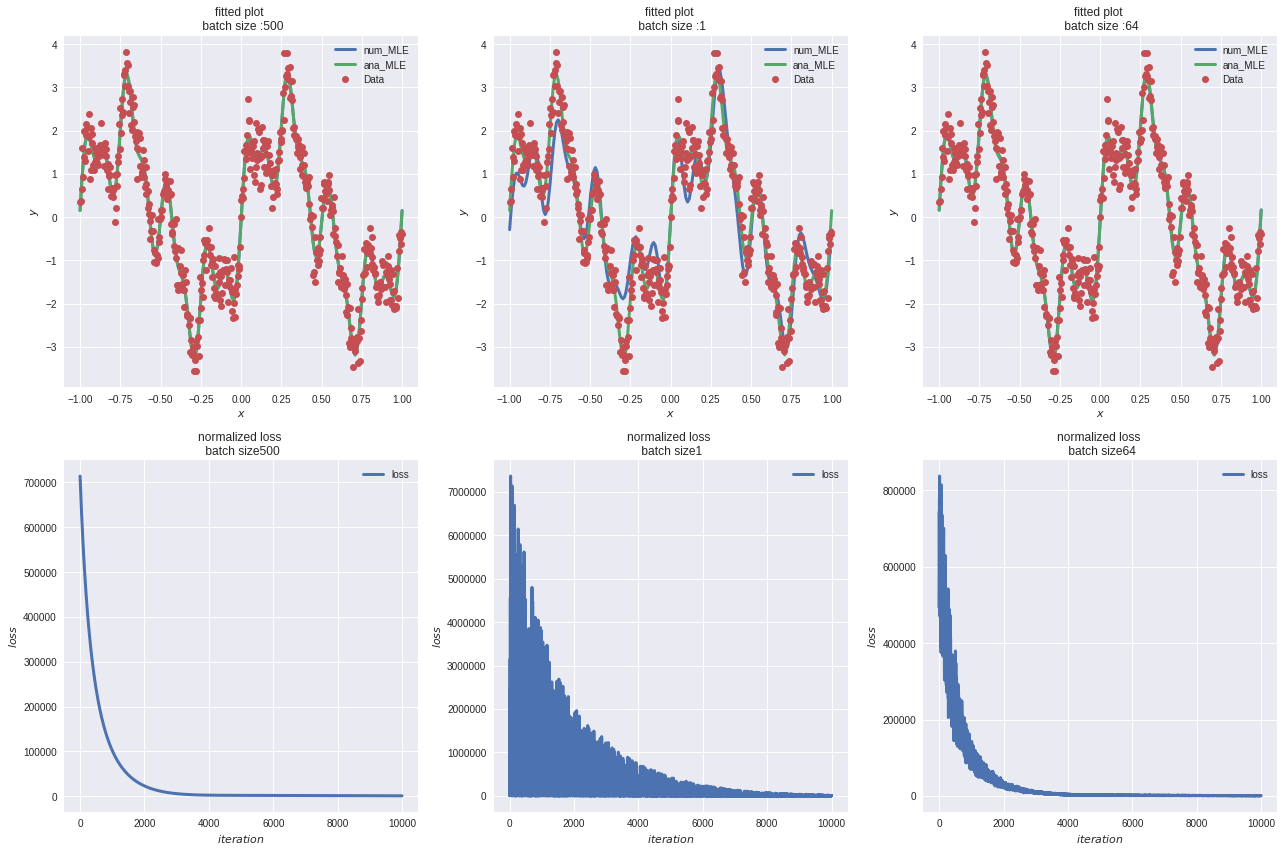

In [0]:
fig_locator = 1
for batch_size in [X.shape[0],1,64]:
  
  plt.figure(1, figsize=(18,12))
  plt.subplot(2,3,fig_locator)
  lin_reg = LinearRegression(expanded_X,y,batch_size)
  m = BayesianLinearRegression(expanded_X, y, alpha, beta)
  w,loss = lin_reg.optimize(learning_rate = .001)
  w_MLE = m.fit_MLE()
  # plots!
  X_star = np.linspace(-1,1,200)[:,None]
  expanded_X_star = basis_selector(X_star,200,16)
  y_pred_num_MLE = np.matmul(expanded_X_star, w)
  y_analytical_MLE = np.matmul(expanded_X_star,w_MLE)
  plt.plot(X_star, y_pred_num_MLE, linewidth=3.0, label = 'num_MLE')
  plt.plot(X_star, y_analytical_MLE, linewidth=3.0, label = 'ana_MLE')
  plt.plot(X,y,'o', label = 'Data')
  plt.legend()
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('fitted plot \n batch size :' + str(batch_size))
  plt.tight_layout()
  plt.subplot(2,3,fig_locator + 3)
  plt.plot(loss / batch_size, linewidth=3.0, label = 'loss')
  plt.legend()
  plt.xlabel('$iteration$')
  plt.ylabel('$loss$')
  plt.title('normalized loss \n batch size'+ str(batch_size))
  fig_locator += 1

In terms of the training loss, as we reduce the size in the batch, we see that oscillation is getting larger. 
Apparently, ths oscillation brings relatively worse fit with batch size of one. 

Below, we will see the impact of learning rate.


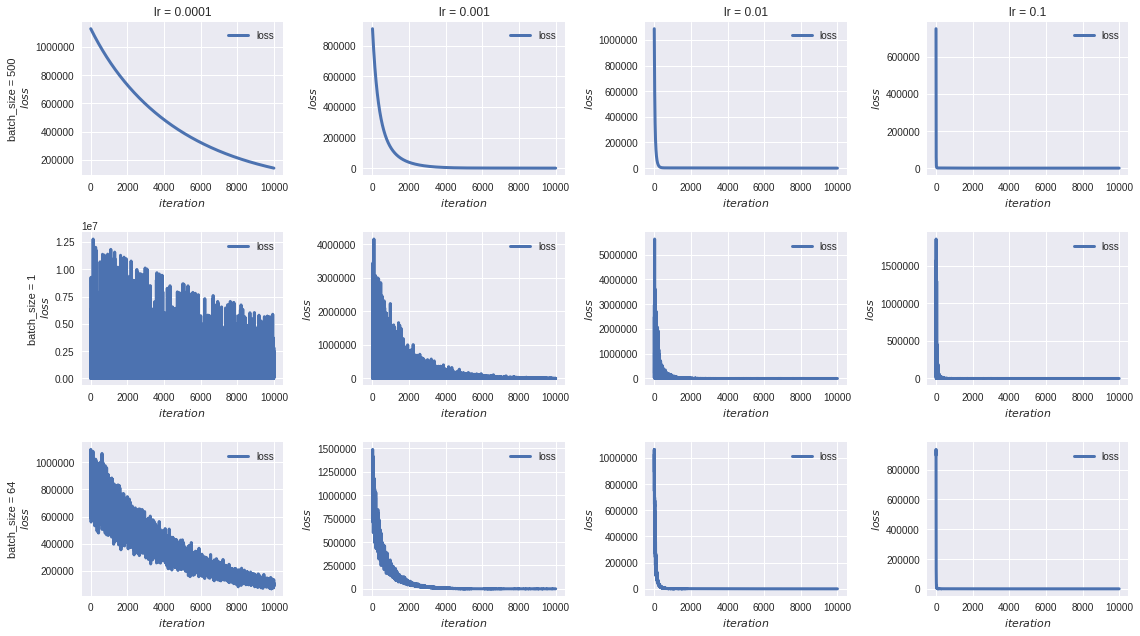

In [0]:
fig_locator = 1
for batch_size in [X.shape[0],1,64]:
  for lr in [.0001,.001,.01,.1]:
    lin_reg = LinearRegression(expanded_X,y,batch_size)
    plt.figure(1, figsize=(16,9))
    plt.subplot(3,4,fig_locator)
    m = BayesianLinearRegression(expanded_X, y, alpha, beta)
    w,loss = lin_reg.optimize(learning_rate = lr)
    plt.plot(loss / batch_size, linewidth=3.0, label = 'loss')
    plt.legend()
    plt.xlabel('$iteration$')
    plt.ylabel('$loss$')
    if fig_locator in [1,5,9,13]:
      plt.ylabel('batch_size = ' + str(batch_size) + '\n $loss$')
    if fig_locator in [1,2,3,4]:
      plt.title('lr = ' + str(lr))
    plt.tight_layout()
    fig_locator += 1

As we increase the learning rate, generally they converge faster and the oscilattion gets smaller.
This tendency is observed across different size of batches.

Contrary to my expectation, the overshoot near the convergence is not apparent when we apply large learning rate on small batch size.
  


---



In [0]:
# q3
class LogisticRegression:
  def __init__(self,X,y):
    self.iteration_num = 20000
    self.beta_one = .9
    self.beta_two = .999
    self.epsilon = 1e-8
    self.X = X
    self.y = y
    self.batch_size = 32
    self.X_y = np.hstack((self.X,self.y))
    
  def forward(self,X,W):
    Z = np.matmul(X,W)
    return  (1 + np.exp( - Z)) ** (- 1)
  def compute_loss(self,W,X,y):
    y_hat = self.forward(X,W)
    loss = - np.sum(y * np.log(y_hat + self.epsilon) + (1 - y) * np.log(1 - y_hat + self.epsilon), axis = 0)
    return loss
  def optimize(self,learning_rate):
    w = np.random.randn(self.X.shape[1],self.y.shape[1])
    m = np.zeros(w.shape)
    v = np.zeros(w.shape)
    grad_loss = grad(self.compute_loss,0)
    loss = np.zeros(self.iteration_num)
    locator = 0
    for iter_num in range(self.iteration_num):
      # shuffle dataset here
      np.random.shuffle(self.X_y)
      self.X = self.X_y[:,:self.X.shape[1]]
      self.y = self.X_y[:,self.X.shape[1]:]
      this_X = self.X[:self.batch_size]
      this_y = self.y[:self.batch_size]
      this_loss_gradient = grad_loss(w,this_X,this_y)
      this_loss = self.compute_loss(w,this_X,this_y)
      loss[locator] = this_loss
      m = self.beta_one * m + (1 - self.beta_one) * this_loss_gradient
      v = self.beta_two * v + (1 - self.beta_two) * np.multiply(this_loss_gradient,this_loss_gradient)
      m_dot = m / (1 - self.beta_one ** (iter_num + 1))
      v_dot = v / (1 - self.beta_two ** (iter_num + 1))
      w = w - learning_rate * m_dot / (np.sqrt(v_dot) + self.epsilon)
      locator += 1
    
    return w,loss

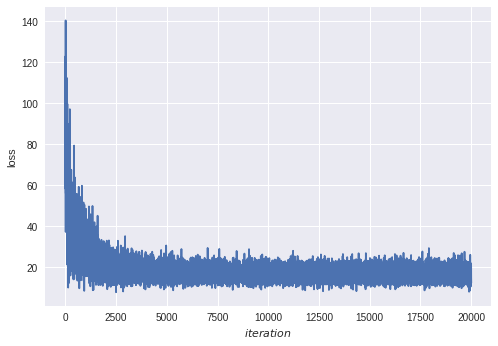

In [53]:
#construct training and test data sets
file = pd.read_csv('Data_for_UCI_named.csv.csv')
lb = LabelBinarizer()
#here unstable is 1 and stable is 0
y_q3 = lb.fit_transform(file['stabf'])
X_q3 = file.drop(columns = ['stab','stabf']).as_matrix()
X_y_q3 = np.hstack([X_q3,y_q3])
np.random.shuffle(X_y_q3)
train_X = X_y_q3[:6667,:-1]
train_y = X_y_q3[:6667,-1].reshape(6667,1)
test_X = X_y_q3[6667:,:-1]
test_y = X_y_q3[6667:,-1].reshape(3333,1)

#logistic regression loss
log_reg = LogisticRegression(train_X,train_y)
w,loss = log_reg.optimize(learning_rate = .001)
plt.plot(loss)
plt.xlabel('$iteration$')
plt.ylabel('loss')
z_pred = np.matmul(test_X,w)
y_pred = np.round((1 + np.exp( - z_pred)) ** -1)
c_met = confusion_matrix(test_y,y_pred)
acc = accuracy_score(test_y,y_pred)

 Accuracy and confusion matrix is printed below 

In [0]:
confusion_table = pd.DataFrame(c_met,columns=['actual_positive','actual negative'],index=['predicted positive','predicted negative'])
print('accuracy = ' + str(acc))
print(confusion_table)

accuracy = 0.7227722772277227
                    actual_positive  actual negative
predicted positive              541              653
predicted negative              271             1868




---

